<a href="https://colab.research.google.com/github/kevingray92/ATMS-597-Project-3-Group-G/blob/master/Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ATMS 597: Project 3

In [191]:
%pylab inline
import xarray as xr
from datetime import datetime
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['datetime', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [192]:
!pip install netcdf4
!pip install pydap

In [0]:
years = np.arange(1996,2020)
#years = np.arange(1996,1998)
#print(years)
file_list = []
associatedyearlist = []

# Get the file names from the website by looping through each year
for year in years:
    page = requests.get('https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/'+str(year)+'/')
    soup = BeautifulSoup(page.text, 'html.parser')

    file_name_list_items = soup.find_all('a')
    file_name_list_items

    i = 0
    for file_name in file_name_list_items:
        # Need an if statement to skip some header lines on each page
        if i > 4:
            names = file_name.contents[0]
            #print(names)
            file_list.append(names)
            associatedyearlist.append(year)
        i = i+1
# We now have a list of file names and their associated years

In [0]:
# Check the length of the lists to make sure we got all that we wanted
len(file_list)
#len(associatedyearlist)

8495

In [0]:
# Test just getting one file
!wget -nv "https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/2018/gpcp_v01r03_daily_d20180101_c20180409.nc"
nc = xr.open_dataset('gpcp_v01r03_daily_d20180101_c20180409.nc')

2020-02-21 20:45:08 URL:https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/2018/gpcp_v01r03_daily_d20180101_c20180409.nc [289938/289938] -> "gpcp_v01r03_daily_d20180101_c20180409.nc.2" [1]


In [0]:
# Check the file contents if you want
nc['precip']

<xarray.DataArray 'precip' (time: 1, latitude: 180, longitude: 360)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * time       (time) object 2018-01-01 00:00:00
Attributes:
    long_name:      NOAA Climate Data Record (CDR) of Daily GPCP Satellite-Ga...
    standard_name:  lwe_precipitation_rate
    units:          mm/day
    valid_range:    [  0. 100.]
    cell_methods:   area: mean time: mean

In [0]:
# This is the loop to get all the data.
# Took roughly 7 hours to complete.
site = 'https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/'
datasets = [] # an empty list that will hold all the precip data arrays
for count in range(len(file_list)):
    file_i, year_i = (file_list[count], associatedyearlist[count])
    fileloc = (site+str(year_i)+'/'+file_i)
    !wget -nv "{fileloc}" # Get the file
    nc = xr.open_dataset(file_i) # read the file into nc
    precip = xr.DataArray(nc['precip'],dims=['time','latitude','longitude']) # load the precip data into a data array 
    datasets.append(precip) #append the datasets list with the precip data array
    !rm "{file_i}" # remove the downloaded file
len(datasets)
combined = xr.concat(datasets, dim='time') # Make one combined file with all the data arrays

Streaming output truncated to the last 5000 lines.
2020-02-22 17:03:43 URL:https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/2006/gpcp_v01r03_daily_d20060428_c20170530.nc [289938/289938] -> "gpcp_v01r03_daily_d20060428_c20170530.nc" [1]
2020-02-22 17:03:46 URL:https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/2006/gpcp_v01r03_daily_d20060429_c20170530.nc [289938/289938] -> "gpcp_v01r03_daily_d20060429_c20170530.nc" [1]
2020-02-22 17:03:49 URL:https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/2006/gpcp_v01r03_daily_d20060430_c20170530.nc [289938/289938] -> "gpcp_v01r03_daily_d20060430_c20170530.nc" [1]
2020-02-22 17:03:52 URL:https://www.ncei.noaa.gov/data/global-precipitation-climatology-project-gpcp-daily/access/2006/gpcp_v01r03_daily_d20060501_c20170530.nc [289938/289938] -> "gpcp_v01r03_daily_d20060501_c20170530.nc" [1]
2020-02-22 17:03:56 URL:https://www.ncei.noaa

In [0]:
# Check the length of datasets to make sure we got everything
len(datasets)
#combined = xr.concat(datasets, dim='time')
#print(datasets[0])

8495

In [0]:
# Save the combined file
combined.to_netcdf('combined.nc')

In [193]:
# or mount Google Drive and then save it there
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Save the combined file on Google Drive
combined.to_netcdf('/content/drive/My Drive/combined.nc')

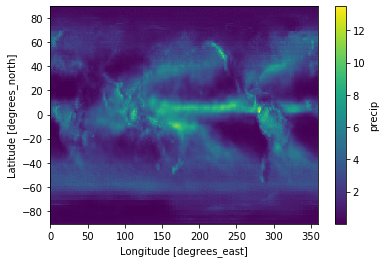

In [0]:
# Plot the data
preciptest = combined.mean('time')
preciptest.plot()

From here on, the 'combined.nc' file can be loaded and then we can begin getting the dates that had rain exceeding the 95th percentile. 

In [0]:
allprecip = xr.open_dataset('/content/drive/My Drive/combined.nc')

In [0]:
def is_ond(month):
    return (month >= 10) & (month <= 12)

precip_OND = allprecip.sel(time=is_ond(allprecip['time.month']))

In [0]:
precipvalues = precip_OND['precip'].sel(latitude=-4.4,longitude=15.3, method='nearest').values
precipvalueslist = precipvalues.tolist()
#precipvalueslist.sort(reverse=True)
#print(precipvalueslist)
#precipvalueslist.index(9.969209968386869e+36)
precipvalueslist[1963]=0.0

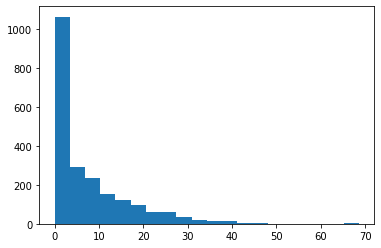

In [197]:
plt.hist(precipvalueslist, bins = 20)
plt.show()

In [249]:
# Get data in a 1x1 degree grid over Kinshasa, Congo
kinshasaraw = precip_OND.sel(latitude=slice(-4.4-1.,-4.4+1.),longitude=slice(15.3-1,15.3+1))
kinshasaraw

<xarray.Dataset>
Dimensions:    (latitude: 2, longitude: 2, time: 2178)
Coordinates:
  * longitude  (longitude) float32 15.0 16.0
  * latitude   (latitude) float32 -5.0 -4.0
  * time       (time) datetime64[ns] 1996-10-01 1996-10-02 ... 2019-11-30
Data variables:
    precip     (time, latitude, longitude) float32 ...

In [0]:
kinshasap95 = kinshasaraw.quantile(0.95,dim='time')
p95value = average(kinshasap95.precip)

In [253]:
np.percentile(kinshasaraw.precip.values,95)


26.38299951553344

In [278]:
# Make a new dataset with only dates exceeding the 95th percentile and also lower than 8000.0 mm to filter out bad data
datesexceeded = kinshasaraw.where((kinshasaraw.precip>=p95value)&(kinshasaraw.precip<=8000.0),drop=True)
datesexceeded.precip.max()

<xarray.DataArray 'precip' ()>
array(96.21347046)

In [279]:
datesexceeded

<xarray.Dataset>
Dimensions:    (latitude: 2, longitude: 2, time: 238)
Coordinates:
  * longitude  (longitude) float32 15.0 16.0
  * latitude   (latitude) float32 -5.0 -4.0
  * time       (time) datetime64[ns] 1996-11-08 1996-11-18 ... 2019-11-26
Data variables:
    precip     (time, latitude, longitude) float32 nan nan 29.301687 ... nan nan

In [281]:
datesexceeded.time.values

array(['1996-11-08T00:00:00.000000000', '1996-11-18T00:00:00.000000000',
       '1996-11-20T00:00:00.000000000', '1996-11-25T00:00:00.000000000',
       '1996-11-30T00:00:00.000000000', '1996-12-06T00:00:00.000000000',
       '1997-10-31T00:00:00.000000000', '1997-11-11T00:00:00.000000000',
       '1997-12-16T00:00:00.000000000', '1997-12-23T00:00:00.000000000',
       '1998-11-08T00:00:00.000000000', '1998-11-17T00:00:00.000000000',
       '1998-11-21T00:00:00.000000000', '1998-12-02T00:00:00.000000000',
       '1999-11-03T00:00:00.000000000', '1999-11-13T00:00:00.000000000',
       '1999-11-15T00:00:00.000000000', '1999-11-17T00:00:00.000000000',
       '1999-11-20T00:00:00.000000000', '1999-11-26T00:00:00.000000000',
       '1999-11-28T00:00:00.000000000', '1999-11-30T00:00:00.000000000',
       '1999-12-25T00:00:00.000000000', '1999-12-27T00:00:00.000000000',
       '1999-12-28T00:00:00.000000000', '2000-10-02T00:00:00.000000000',
       '2000-10-06T00:00:00.000000000', '2000-10-14

In [0]:
datesexceeded.to_netcdf('/content/drive/My Drive/datesexceeded.nc')

From here on, the 'datesexceededclean.nc' file can be loaded and then we can begin plotting the composite fields.